1) CVR curve (done)
2) No statistical significance between model projections via two-sample Kolmogorov-Smirnov test
3) e-family:
    1) Acc vs Radius (averaged over #PCs, over datasets)
    2) Acc vs #PCs (averaged over radius, over datasets)
4) model comparisons: acc vs #pcs
    1) best value points from the e-family (averaged over datasets)
    2) lines for baselines (e-family takes a significantly fewer #PCs to reach reasonable performance)

# Prep

In [19]:
import json
import copy
import cv2
import warnings
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import EpsilonCubeNeighborsClassifier
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.svm import SVC
from scipy.stats import mode, ks_2samp
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from datasets import load_dataset
from datasets.utils.logging import disable_progress_bar

SEED = 2
np.random.seed(SEED)
warnings.filterwarnings('ignore')
disable_progress_bar()

In [20]:
colors = ['r','g','b','y','c','m','k','orange','brown','purple']
model_list = ['all-mpnet-base-v2']#, 'all-distilroberta-v1', 'multi-qa-distilbert-cos-v1', 'gtr-t5-large']
tag_list = ["covid", "drugs", "biomedical", "music", "film", "finance", "law", "computing", "history", "crypto", "chess", "cooking", "astronomy", "fitness", "anime", "literature"]
metric_list = ['proj']#, 'dist']
tag_to_ind = {v:i for i,v in enumerate(tag_list)}
model_to_ind = {v:i for i,v in enumerate(model_list)}
msmarco_tags = tag_list[2:8]
stackexchange_tags = tag_list[8:]

radiuses = [0.01] + list(map(lambda x: x/1000, range(0, 301, 20)))[1:]
n_pcs_bundle = list(range(1,20))+list(range(20,180,20))

clf_dict = {
    "eball": RadiusNeighborsClassifier,
    "ecube": EpsilonCubeNeighborsClassifier,
    "erect": EpsilonCubeNeighborsClassifier,
    "logreg": LogisticRegression,
    "svm": SVC,
    "kmeans": KMeans,
    "gmm": GaussianMixture
}
clf_args_dict = {
    "eball": {"outlier_label": 0},
    "ecube": {"outlier_label": 0},
    "erect": {"outlier_label": 0},
    "logreg": {},
    "svm": {"kernel": "linear"},
    "kmeans": {"n_clusters": 2, "random_state": SEED},
    "gmm": {"n_components": 2, "random_state": SEED},
}
# lowest std: 0.005
# highest std: 0.2

# shape: (#models, #tags, #samples, hidden_dim)
d_embs = [[np.load(fr"embeddings\d_emb_{model}_{i}.npy") for i in range(15)] for model in model_list]
q_embs = [[np.load(fr"embeddings\q_emb_{model}_{i}.npy") for i in range(15)] for model in model_list]
pcs = [[np.load(fr"embeddings\pc_{model}_{i}.npy") for i in range(15)] for model in model_list]
best_n_pcs = [[np.load(fr"embeddings\best_n_pcs_{model}_{i}.npy") for i in range(15)] for model in model_list]
projections = [[np.load(fr"embeddings\projection_{model}_{i}.npy") for i in range(15)] for model in model_list]
distances = [[np.load(fr"embeddings\distance_{model}_{i}.npy") for i in range(15)] for model in model_list]

# CVR vs #PCs

In [1]:
# cvrs = [get_cvrs(d_emb_per_model) for d_emb_per_model in d_embs]
# cvr_mean = [np.nanmean(cvr, axis=0) for cvr in cvrs]
# cvr_std = [np.nanstd(cvr, axis=0) for cvr in cvrs]
# xs = np.arange(768)
# plt.rcParams['figure.figsize'] = (16,12)
# for i in range(4):
#     plt.plot(xs, cvr_mean[i], color=colors[i], label=model_list[i])
#     plt.fill_between(xs, cvr_mean[i]-cvr_std[i], cvr_mean[i]+cvr_std[i], facecolor=colors[i], alpha=0.5)
# plt.legend()
# plt.grid(visible=True)
# plt.title("Cumulative Explained Variance Ratio across all 15 domains (line = mean; shade = std)")
# plt.xlabel("#PCs")
# plt.ylabel("Cumulative Explained Variance Ratio")
# plt.show()

# Encoder Comparison

In [2]:
# def show_pvalues(a,b):
# print("Projections")
# for i,_ in enumerate(tag_list):
#     print(round(np.mean([ks_2samp(projections[0][i][j], projections[1][i][j]).pvalue for j in range(len(projections[0][i]))]),3))

# print("Distances")
# for i,_ in enumerate(tag_list):
#     print(round(np.mean([ks_2samp(distances[0][i][j], distances[1][i][j]).pvalue for j in range(len(distances[0][i]))]),3))

# Best results

In [21]:
def read_results(method):
    if method in ("ecube", "erect"):
        results = {}
        for tag in tag_list:
            if tag != "biomedical":
                temp = ''
                with open(fr'all_results_{method}_OOS_{tag}.txt','r') as f:
                    for i in f.readlines():
                        temp = i
                results[tag] = eval(temp)
    else:
        results = ''
        with open(fr'all_results_{method}_OOS.txt','r') as f:
            for i in f.readlines():
                results = i
        results = eval(results)
    return results

In [22]:
results_eball = read_results("eball")
results_ecube = read_results("ecube")
results_erect = read_results("erect")
results_logreg = read_results("logreg")
results_svm = read_results("svm")
results_gmm = read_results("gmm")

In [23]:
for tag in tag_list:
    if tag != "biomedical":
        print(tag)
        print("eball ", sorted(results_eball[tag].items(), key=lambda x:(x[1], -x[0][-1], -x[0][-2]), reverse=True)[0])
        print("ecube ", sorted(results_ecube[tag].items(), key=lambda x:(x[1], -x[0][-1], -x[0][-2]), reverse=True)[0])
        print("erect ", sorted(results_erect[tag].items(), key=lambda x:(x[1], -x[0][-1], -x[0][-2]), reverse=True)[0])
        print("logreg", (n_pcs_bundle[results_logreg[tag].index(max(results_logreg[tag]))], max(results_logreg[tag])))
        print("svm   ", (n_pcs_bundle[results_svm[tag].index(max(results_svm[tag]))], max(results_svm[tag])))
        print("gmm   ", (n_pcs_bundle[results_gmm[tag].index(max(results_gmm[tag]))], max(results_gmm[tag])))
        print()

covid
eball  ((15, 5), 0.9473684210526315)
ecube  ((7, 3), 0.9210526315789473)
erect  ((12, 0, 2), 0.8947368421052632)
logreg (160, 0.9210526315789473)
svm    (40, 0.8947368421052632)
gmm    (3, 0.8947368421052632)

drugs
eball  ((15, 9), 0.9761904761904762)
ecube  ((5, 3), 0.9523809523809523)
erect  ((7, 1, 2), 0.8809523809523809)
logreg (60, 0.9920634920634921)
svm    (60, 0.9920634920634921)
gmm    (12, 0.9523809523809523)

music
eball  ((12, 10), 0.9097222222222222)
ecube  ((4, 4), 0.9069444444444444)
erect  ((4, 1, 2), 0.8722222222222222)
logreg (160, 0.9555555555555556)
svm    (160, 0.9569444444444445)
gmm    (8, 0.8986111111111111)

film
eball  ((8, 6), 0.9037698412698413)
ecube  ((4, 4), 0.8928571428571429)
erect  ((2, 2, 2), 0.8740079365079365)
logreg (160, 0.9384920634920635)
svm    (160, 0.935515873015873)
gmm    (11, 0.9216269841269841)

finance
eball  ((8, 7), 0.9087628865979381)
ecube  ((4, 5), 0.8994845360824743)
erect  ((1, 3, 2), 0.8381443298969072)
logreg (160, 0.9298

In [25]:
best_acc_eball = np.mean([sorted(results_eball[tag].items(), key=lambda x:(x[1], -x[0][-1], -x[0][-2]), reverse=True)[0][1] for tag in tag_list if tag != "biomedical"])
best_acc_ecube = np.mean([sorted(results_ecube[tag].items(), key=lambda x:(x[1], -x[0][-1], -x[0][-2]), reverse=True)[0][1] for tag in tag_list if tag != "biomedical"])
best_acc_erect = np.mean([sorted(results_erect[tag].items(), key=lambda x:(x[1], -x[0][-1], -x[0][-2]), reverse=True)[0][1] for tag in tag_list if tag != "biomedical"])
best_acc_logreg = np.mean([max(results_logreg[tag]) for tag in tag_list if tag != "biomedical"])
best_acc_svm = np.mean([max(results_svm[tag]) for tag in tag_list if tag != "biomedical"])
best_acc_gmm = np.mean([max(results_gmm[tag]) for tag in tag_list if tag != "biomedical"])

print("Mean Best #Acc")
print(best_acc_eball)
print(best_acc_ecube)
print(best_acc_erect)
print(best_acc_logreg)
print(best_acc_svm)
print(best_acc_gmm)

Mean Best #Acc
0.9162971499695114
0.9058878778855153
0.8526738394926315
0.9526015168360303
0.9511581364747694
0.9297417205581645


In [26]:
best_n_pcs_eball = np.mean([sorted(results_eball[tag].items(), key=lambda x:(x[1], -x[0][-1], -x[0][-2]), reverse=True)[0][0][1] for tag in tag_list if tag != "biomedical"])
best_n_pcs_ecube = np.mean([sorted(results_ecube[tag].items(), key=lambda x:(x[1], -x[0][-1], -x[0][-2]), reverse=True)[0][0][1] for tag in tag_list if tag != "biomedical"])
best_n_pcs_erect = np.mean([sorted(results_erect[tag].items(), key=lambda x:(x[1], -x[0][-1], -x[0][-2]), reverse=True)[0][0][1] for tag in tag_list if tag != "biomedical"])
best_n_pcs_logreg = np.mean([n_pcs_bundle[results_logreg[tag].index(max(results_logreg[tag]))] for tag in tag_list if tag != "biomedical"])
best_n_pcs_svm = np.mean([n_pcs_bundle[results_svm[tag].index(max(results_svm[tag]))] for tag in tag_list if tag != "biomedical"])
best_n_pcs_gmm = np.mean([n_pcs_bundle[results_gmm[tag].index(max(results_gmm[tag]))] for tag in tag_list if tag != "biomedical"])

print("Mean Best #PCs")
print(best_n_pcs_eball)
print(best_n_pcs_ecube)
print(best_n_pcs_erect)
print(best_n_pcs_logreg)
print(best_n_pcs_svm)
print(best_n_pcs_gmm)

Mean Best #PCs
6.466666666666667
4.333333333333333
1.5333333333333334
138.66666666666666
128.0
50.46666666666667


# Acc vs #PCs

In [27]:
def get_best_avg_efamily(results):
    best = [sorted(results[tag].items(), key=lambda x:(x[1], -x[0][-1], -x[0][-2]), reverse=True)[0] for tag in tag_list if tag != "biomedical"]
    best_n_pcs = np.mean([item[0][1] for item in best])
    best_acc = np.mean([item[1] for item in best])
    return best_n_pcs, best_acc

def get_avg_efamily(results):
    return pd.DataFrame(results).reset_index().groupby("level_1").max().drop("level_0",axis=1).mean(axis=1).tolist()

def get_avg_efamily_per_radius(results):
    return pd.DataFrame(results).reset_index().groupby("level_0").mean().drop("level_1",axis=1).mean(axis=1).tolist()

def get_avg_baseline(results):
    return np.mean(np.vstack([v for k,v in results.items() if k != "biomedical"]), axis=0)

In [28]:
# best_eball_n_pcs, best_eball_acc = get_best_avg_efamily(results_eball)
# best_ecube_n_pcs, best_ecube_acc = get_best_avg_efamily(results_ecube)
# best_erect_n_pcs, best_erect_acc = get_best_avg_efamily(results_erect)
best_eball = get_avg_efamily(results_eball)
best_ecube = get_avg_efamily(results_ecube)
best_erect = get_avg_efamily(results_erect)
best_logreg = get_avg_baseline(results_logreg)
best_svm = get_avg_baseline(results_svm)
best_gmm = get_avg_baseline(results_gmm)

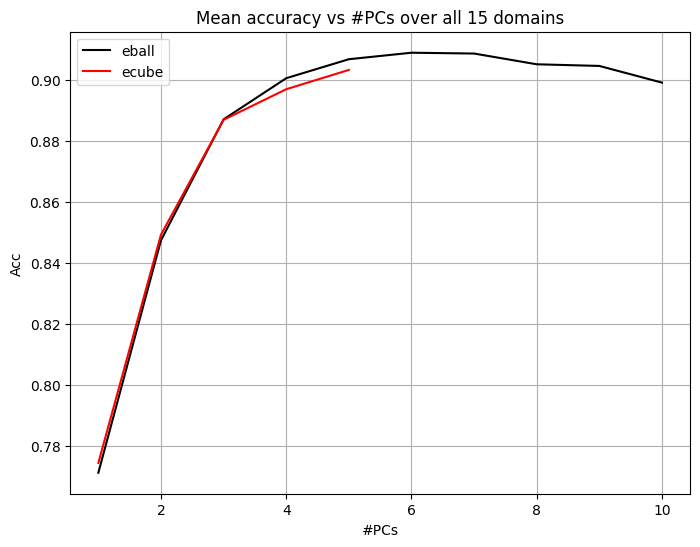

In [31]:
plt.rcParams['figure.figsize'] = (8,6)
plt.plot(list(range(1,11)), best_eball, color="black", label="eball")
plt.plot(list(range(1,6)), best_ecube, color="r", label="ecube")
# plt.plot(list(range(1,11)), best_erect, color="g", label="erect")
plt.legend()
plt.grid(True)
plt.title("Mean accuracy vs #PCs over all 15 domains")
plt.xlabel("#PCs")
plt.ylabel("Acc")
plt.show()

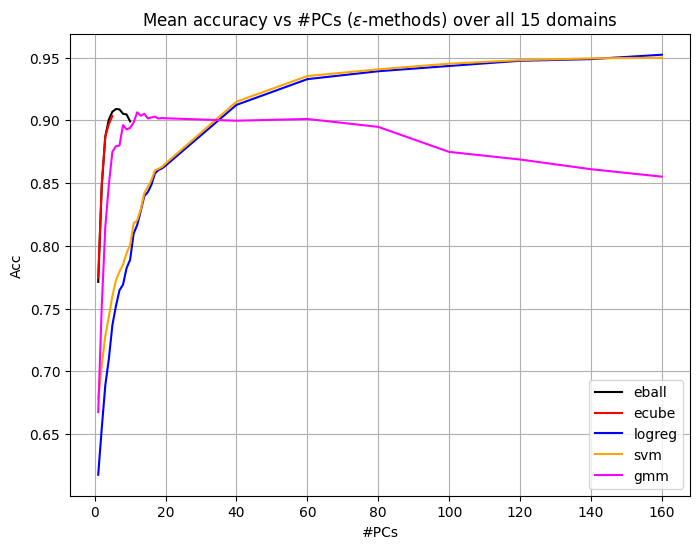

In [32]:
plt.rcParams['figure.figsize'] = (8,6)
plt.plot(list(range(1,11)), best_eball, color="black", label="eball")
plt.plot(list(range(1,6)), best_ecube, color="r", label="ecube")
# plt.plot(list(range(1,11)), best_erect, color="g", label="erect")
plt.plot(n_pcs_bundle, best_logreg, color="b", label="logreg")
plt.plot(n_pcs_bundle, best_svm, color="orange", label="svm")
plt.plot(n_pcs_bundle, best_gmm, color="magenta", label="gmm")
# plt.scatter(best_eball_n_pcs, best_eball_acc, c="black", marker="*", label="eball")
# plt.scatter(best_ecube_n_pcs, best_ecube_acc, c="r", marker="*", label="ecube")
# plt.scatter(best_erect_n_pcs, best_erect_acc, c="g", marker="*", label="erect")
plt.legend()
plt.grid(True)
plt.title("Mean accuracy vs #PCs ($\epsilon$-methods) over all 15 domains")
plt.xlabel("#PCs")
plt.ylabel("Acc")
plt.show()

# Acc vs Radius (e-family)

In [33]:
best_eball = get_avg_efamily_per_radius(results_eball)
best_ecube = get_avg_efamily_per_radius(results_ecube)
best_erect = get_avg_efamily_per_radius(results_erect)

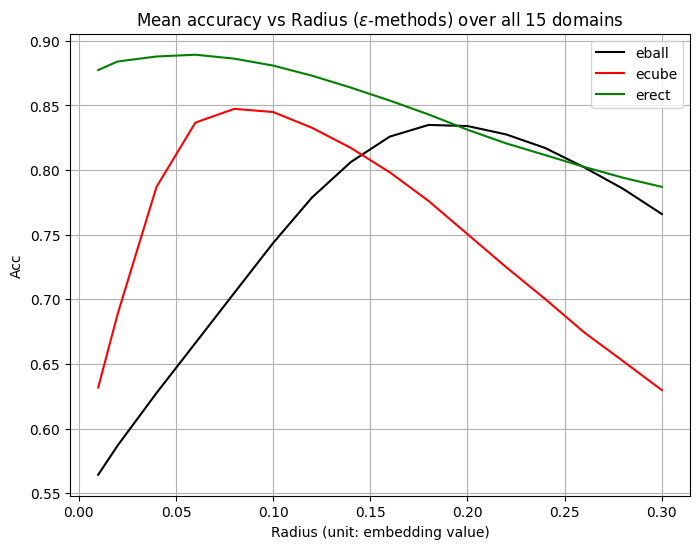

In [35]:
plt.rcParams['figure.figsize'] = (8,6)
plt.plot(radiuses, best_eball, color="black", label="eball")
plt.plot(radiuses, best_ecube, color="r", label="ecube")
plt.plot(radiuses, best_erect, color="g", label="erect")
plt.legend()
plt.grid(True)
plt.title("Mean accuracy vs Radius ($\epsilon$-methods) over all 15 domains")
plt.xlabel("Radius (unit: embedding value)")
plt.ylabel("Acc")
plt.show()

# Top results comparison

In [ ]:
# best performance per domain
taglist = ["covid", "drugs", "biomedical", "music", "film", "finance", "law", "computing", "history", "crypto", "travel", "chemistry", "philosophy", "anime", "gaming"]
res_bundle = {
    "eball": [sorted(results_eball[tag].items(), key=lambda x:x[1], reverse=True)[0] for tag in taglist],
    "ecube": [sorted(results_ecube[tag].items(), key=lambda x:x[1], reverse=True)[0] for tag in taglist]
}

xs = np.arange(len(taglist))
width = 0.25
multiplier = 0

fig, ax = plt.subplots()
for method, result in res_bundle.items():
    offset = width*multiplier
    rects = ax.bar(xs+offset, [res[1] for res in result], width, label=method)
    ax.bar_label(rects, [res[0] for res in result], padding=3)
    multiplier += 1
ax.set_title('Penguin attributes by species')
ax.legend()
ax.set_xticks(xs + width, taglist)
ax.set_ylabel('Acc')
ax.set_ylim(0.5, 1)
plt.show()

In [138]:
taglist = ["covid", "drugs", "biomedical", "music", "film", "finance", "law", "computing", "history", "crypto", "travel", "chemistry", "philosophy", "anime", "gaming"]
res_bundle = {
    "eball": [sorted(results_eball[tag].items(), key=lambda x:(x[1], -x[0][1], -x[0][0]), reverse=True)[0] for tag in taglist],
    "ecube": [sorted(results_ecube[tag].items(), key=lambda x:(x[1], -x[0][1], -x[0][0]), reverse=True)[0] for tag in taglist]
}
df = pd.DataFrame(res_bundle, index=taglist).reset_index().rename({"index":"domain"}, axis=1)
df = pd.melt(df, id_vars=["domain"], value_vars=["eball","ecube"]).rename({"variable": "method"}, axis=1)
df["setting"] = df["value"].apply(lambda x:x[0])
df["acc"] = df["value"].apply(lambda x:x[1])
df.drop("value", axis=1, inplace=True)

In [84]:
# taglist = ["covid", "drugs", "biomedical", "music", "film", "finance", "law", "computing", "history", "crypto", "travel", "chemistry", "philosophy", "anime", "gaming"]
# res_bundle = {
#     "ecube": [sorted(results_ecube[tag].items(), key=lambda x:(x[1], -x[0][1], -x[0][0]), reverse=True)[0] for tag in taglist],
#     # "ecube": [sorted(results_ecube[tag].items(), key=lambda x:(x[1], -x[0][1], -x[0][0]), reverse=True)[0] for tag in taglist]
# }
# df2 = pd.DataFrame(res_bundle, index=taglist).reset_index().rename({"index":"domain"}, axis=1)
# df2 = pd.melt(df2, id_vars=["domain"], value_vars=["ecube"]).rename({"variable": "method"}, axis=1)
# df2["setting"] = df2["value"].apply(lambda x:x[0])
# df2["acc"] = df2["value"].apply(lambda x:x[1])
# df2.drop("value", axis=1, inplace=True)

In [ ]:
pd.merge(df,df2,on="domain")

In [100]:
results_eball_over_domains = {}
for domain,bundle in results_eball.items():
    if domain != "covid":
        for tup,acc in bundle.items():
            results_eball_over_domains[tup] = results_eball_over_domains.get(tup,0)+acc
results_eball_over_domains = {tup:acc/(len(taglist)-1) for tup,acc in results_eball_over_domains.items()}

In [102]:
results_ecube_over_domains = {}
for domain,bundle in results_ecube.items():
    if domain != "covid":
        for tup,acc in bundle.items():
            results_ecube_over_domains[tup] = results_ecube_over_domains.get(tup,0)+acc
results_ecube_over_domains = {tup:acc/(len(taglist)-1) for tup,acc in results_ecube_over_domains.items()}

In [124]:
xs = radiuses
ys = [v for k,v in sorted(results_eball_over_domains.items(), key=lambda x:x[0]) if k[1]==1]

In [125]:
xticks = [x/100 for x in list(range(0,61,5))]
xticks[0] = 0.01

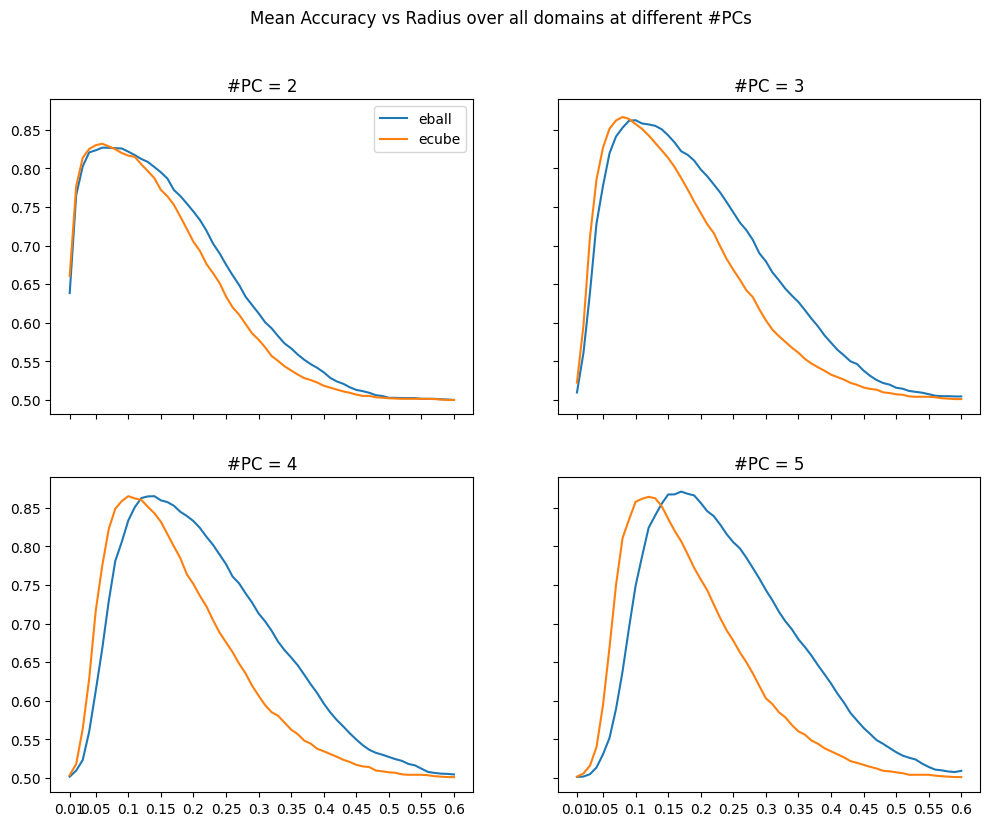

In [133]:
fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=(12,9))
ys = [v for k,v in sorted(results_eball_over_domains.items(), key=lambda x:x[0]) if k[1]==1]
axes[0,0].plot(xs,ys,label="eball")
ys = [v for k,v in sorted(results_ecube_over_domains.items(), key=lambda x:x[0]) if k[1]==1]
axes[0,0].plot(xs,ys,label="ecube")
axes[0,0].legend()
axes[0,0].set_title("#PC = 2")

ys = [v for k,v in sorted(results_eball_over_domains.items(), key=lambda x:x[0]) if k[1]==2]
axes[0,1].plot(xs,ys,label="eball")
ys = [v for k,v in sorted(results_ecube_over_domains.items(), key=lambda x:x[0]) if k[1]==2]
axes[0,1].plot(xs,ys,label="ecube")
axes[0,1].set_title("#PC = 3")

ys = [v for k,v in sorted(results_eball_over_domains.items(), key=lambda x:x[0]) if k[1]==3]
axes[1,0].plot(xs,ys,label="eball")
ys = [v for k,v in sorted(results_ecube_over_domains.items(), key=lambda x:x[0]) if k[1]==3]
axes[1,0].plot(xs,ys,label="ecube")
axes[1,0].set_xticks(xticks,xticks)
axes[1,0].set_title("#PC = 4")

ys = [v for k,v in sorted(results_eball_over_domains.items(), key=lambda x:x[0]) if k[1]==4]
axes[1,1].plot(xs,ys,label="eball")
ys = [v for k,v in sorted(results_ecube_over_domains.items(), key=lambda x:x[0]) if k[1]==4]
axes[1,1].plot(xs,ys,label="ecube")
axes[1,1].set_xticks(xticks,xticks)
axes[1,1].set_title("#PC = 5")
fig.suptitle("Mean Accuracy vs Radius over all domains at different #PCs")
plt.show()

In [137]:
df

,domain,method,setting,acc
0,covid,eball,"(24, 2)",0.921053
1,drugs,eball,"(13, 3)",0.976190
2,biomedical,eball,"(19, 5)",0.905000
3,music,eball,"(18, 5)",0.890000
4,film,eball,"(19, 6)",0.910000
5,finance,eball,"(27, 10)",0.875000
6,law,eball,"(8, 2)",0.875000
7,computing,eball,"(18, 5)",0.860000
8,history,eball,"(17, 4)",0.860000
9,crypto,eball,"(12, 3)",0.910000


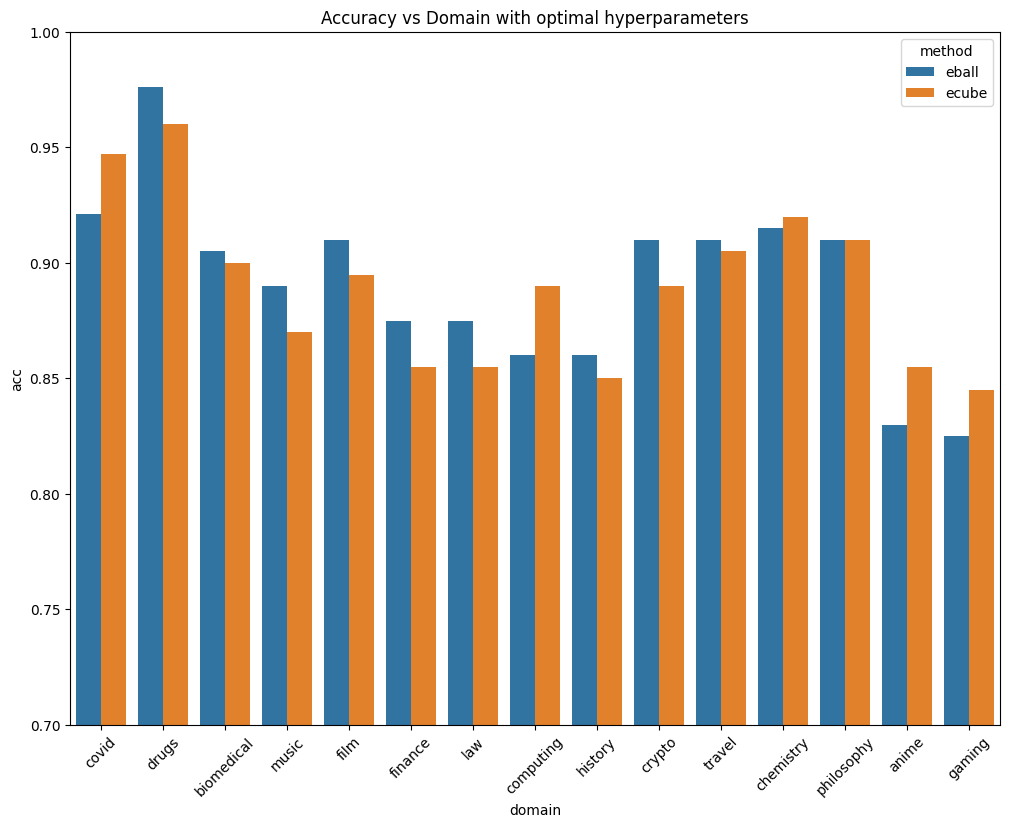

In [146]:
# labels = [df[df["method"]=="eball"]["setting"].tolist(), df[df["method"]=="ecube"]["setting"].tolist()]
plt.rcParams['figure.figsize'] = (12,9)
ax = sns.barplot(df, x="domain", y="acc", hue="method")
# for container in ax.containers:
#     ax.bar_label(container)
plt.ylim(0.7,1)
plt.xticks(rotation=45)
plt.title("Accuracy vs Domain with optimal hyperparameters")
plt.show()